# 4.5.1 Unsupervised Learning Capstone

1. pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from collections import Counter

import re
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET
import os
from time import time

## Exploring corpora to use for this project

The following corpora are from the [University of Oxford Text Archive](https://ota.ox.ac.uk/) :
* 2518 is [The Electronic Text Corpus of Sumerian Literature. Revised edition](https://ota.ox.ac.uk/desc/2518)
* 2554 is [British National Corpus](https://ota.ox.ac.uk/desc/2554)

There is also a corpus of blog entries: [Blog Authorship Corpus](https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm)


In [2]:
path_s = '/Users/gemma/Documents/data science/2518_from_oxford/2518/etcsl/translations/'

files_s = os.listdir(path_s)

In [3]:
path_BNC = '/Users/gemma/Documents/data science/2554_from_oxford/2554/download/Texts/'

# levels are:  download/ Texts / 1 letter /  2 letters / XML files

one_letter = os.listdir(path_BNC)

filenames_BNC = []

for i, letter in enumerate(one_letter):
    # ignore the .DS_store file 
    if one_letter[i][0] != '.':
        two_letters = os.listdir(path_BNC+letter+'/')

        for pair in two_letters:
            if pair[0] != '.': # ignore the .DS_store file again
                all_files = os.listdir(path_BNC+letter+'/'+pair+'/')
                
                for file in all_files:
                    filenames_BNC.append(path_BNC+letter+'/'+pair+'/'+file)
        

After taking a look at the Sumerian translations, it seems like the text is fragmented and as a result may be difficult to parse.

The BNC covers many different topics and that won't fulfill the requirements of this project.

Looking at the blog posts, let's first get the file path and create a list of the filenames to read in from.

# Part 1 - Getting and organizing the data

In [4]:
path_blogs = '/Users/gemma/Documents/data science/blogs/'
blog_files = os.listdir(path_blogs)

In [5]:
# looking at the structure of the filename
blog_files[2]

'3954575.female.23.BusinessServices.Gemini.xml'

Let's see how many blogs we're working with:

In [6]:
len(blog_files)

19320

Next, I'll try to read one blog in and take a look at the structure inside the file.

In [7]:
#file = filenames_BNC[5]   # the BNC

file = path_blogs+blog_files[3] # blogs

#file = path_s+files_s[0]   # sumerian texts

print(file)

# parse the tree and get the root to iterate from later

tree = ET.parse(file)
root = tree.getroot()

/Users/gemma/Documents/data science/blogs/3364931.male.16.Student.Virgo.xml


It looks like there is an issue parsing in the file to the tree due to the character <code>& nbsp;</code>. Let's go through the files, replace all the <code>& nbsp;</code>s with spaces, and then see if it'll work.

Some useful info on reading in files in general and the different modes you can read them in / write them in: [here](https://www.guru99.com/reading-and-writing-files-in-python.html#3).

Also info about how to make the tree from a string was found on [stack overflow](https://stackoverflow.com/questions/647071/python-xml-elementtree-from-a-string-source).

In [8]:
def file_to_string(filename):
    
    f=open(filename, "r") #open the file in read mode. don't change it2 write, otherwise... :D

    if f.mode == 'r': # double check that it's in read mode
        text = f.read() # read the file to the text
    
    space = re.compile('&nbsp;') # this was preventing it from parsing straight from the file
    text = re.sub(space, " ", text) # sub the problem char out with a space
    
    #sometimes & is used as and or is just in the text - accounting for those situations
    
    andd = re.compile('& _&_<>_>.<')
    text = re.sub(andd, "and ", text) #
    
    #randomand = re.compile('&')
    #text = re.sub(randomand, "", text)
    
    #ugh = re.compile('<>')
    #text = re.sub(ugh, "", text)
    
    #face = re.compile('>.<')
    #text = re.sub(face, "", text)
    
    return text

Let's take a look at all of the elements in the tree.

In [9]:
set([elem.tag for elem in root.iter()])

# another way to look at the structure of the doc: 

#for thing in root.getiterator():
#    print(thing)

{'Blog', 'date', 'post'}

Next, in order to create the dataframe, let's create a function to get the data out of each xml file that has been parsed to a string with the function defined above.

Let's also use the previously used text cleaner function to clean up the text in each post.

In [10]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [11]:
# before using this function, i'll have to remember to define the 3 lists 

def split_data(filename, dates, posts, authors):

    file_as_text = file_to_string(path_blogs+filename)
    #file_as_text = file_to_string(filename)
        
    # since we are going to get the tree from a string and not a file 
    # we can't use ET.parse, and will use the following
    
    tree = ET.ElementTree(ET.fromstring(file_as_text))
    root = tree.getroot()

    for post_date in root.findall('date'):
        
        # replace the , with . so the structure is consistent
        date_split = re.sub(r",", "-", post_date.text)
        dates.append(date_split)
        
        authors.append(filename)
        
    for post_itself in root.findall('post'):
        
        cleaned = text_cleaner(post_itself.text)
        posts.append(cleaned)
    
    return 

We'll pick 250 files randomly to try to read in data from, to use in the dataframe. Then we'll have extra files in case a significant amount of them have errors and can't be read in on a first try. 

In [12]:
selected = np.random.choice(blog_files,250)

<em>Info about error handling from [here](https://docs.python.org/3/tutorial/errors.html)</em>

In [13]:
# the lists (and 1 dict) are 

dates = []
posts = []
authors = []

count = 0

for i, file in enumerate(selected):
    try:
        split_data(file, dates, posts, authors)    
    except:
        #UnicodeDecodeError:
        print('Error with {}'.format(i))
        count+=1
    
print('error count = {}'.format(count))

Error with 2
Error with 3
Error with 5
Error with 6
Error with 11
Error with 14
Error with 17
Error with 20
Error with 22
Error with 24
Error with 25
Error with 33
Error with 35
Error with 36
Error with 37
Error with 43
Error with 44
Error with 47
Error with 48
Error with 49
Error with 50
Error with 53
Error with 54
Error with 56
Error with 57
Error with 61
Error with 63
Error with 64
Error with 66
Error with 74
Error with 76
Error with 78
Error with 87
Error with 88
Error with 91
Error with 97
Error with 98
Error with 101
Error with 102
Error with 105
Error with 106
Error with 107
Error with 108
Error with 109
Error with 115
Error with 121
Error with 126
Error with 128
Error with 131
Error with 132
Error with 134
Error with 135
Error with 136
Error with 139
Error with 140
Error with 151
Error with 152
Error with 155
Error with 160
Error with 164
Error with 165
Error with 168
Error with 172
Error with 182
Error with 187
Error with 188
Error with 190
Error with 191
Error with 194
Error 

In [14]:
# make a dictionary from authors to create the dataframe from there

author_dict = {}

for i, value in enumerate(authors):
    separated = value.split(".")
    author_dict[i] = separated[:-1]


In [15]:
df = pd.DataFrame.from_dict(data=author_dict, orient='index', columns=['author_id', 'gender', 
                                                       'age', 'industry', 'sign'] )

df['date'] = dates
df['post'] = posts

In [16]:
df.head()

,author_id,gender,age,industry,sign,date,post
0,2237917,male,48,Technology,Cancer,30-June-2004,urlLink Are the Browser Wars Back? - How Mozil...
1,2237917,male,48,Technology,Cancer,29-June-2004,urlLink Feds warn against Microsoft's browser ...
2,2237917,male,48,Technology,Cancer,29-June-2004,urlLink Business 2.0 - Magazine Article - The ...
3,2237917,male,48,Technology,Cancer,29-June-2004,urlLink Fast Growth Database NICE!!! GHA Techn...
4,2237917,male,48,Technology,Cancer,28-June-2004,urlLink Survey: Dell customer satisfaction uns...


In [17]:
nlp = spacy.load('en_core_web_lg')

df['parsed'] = df['post'].apply(nlp)

I found that some of the months are not in English, which leads to the assumption that some of the posts are not in English. Originally I just replaced the months with the english but the analysis of the text won't work since we are only loading the English language.

I'll use Google Cloud API to check the language of each row, and then drop rows that aren't in English. I used these resources: [Translation API Client Libraries](https://cloud.google.com/translate/docs/reference/libraries) (and [explicitly adding credentials](https://cloud.google.com/docs/authentication/production)) and [Detecting the lang of a string](https://cloud.google.com/translate/docs/detecting-language#translate_detect_language-python) . 

Another resource - [lang detect](https://pypi.org/project/langdetect/).

In [18]:
#export GOOGLE_APPLICATION_CREDENTIALS="""/Users/gemma/Documents/data science/DS Bootcamp/
#                                         My First Project-901fbdcc624d.json"""

# Imports the Google Cloud client library
from google.cloud import translate

# Instantiates a client
translate_client = translate.Client.from_service_account_json(
        '/Users/gemma/Documents/data science/DS Bootcamp/My First Project-901fbdcc624d.json')


In [19]:
# running this on the whole sries made me hit the quota on the79th row, so im
# just going to look at the first 50 char of each post

def check_fifty_char(series):
    return translate_client.detect_language(series[:15])

df['lang'] = df['post'].apply(check_fifty_char)


In [20]:
def check_lang(series):
    if series['language'] != "en":
        series = np.nan
    return

# substitute non english with NaN
df['lang'].apply(check_lang)

# drop the rows of NaN - can't use non English data in this analysis 
df.dropna(axis=0, how='any', inplace=True)


In [21]:
# now that we're done with the language column, let's drop it 

df.drop('lang', axis=1, inplace=True)

In [22]:
# someone has julio, agosto, and maj in their date but the post is still in english
df[df['date'].str.contains("maj")]

,author_id,gender,age,industry,sign,date,post,parsed


In [27]:
# some months either in other langs (which will bring some other issues later on) or 
# just spelled wrong
#replacing = {"Mai":"May", "mayo": "May", "mei": "May", "Agosto":"August", "juli":"July", 
#             "Julho":"July", "Juli":"July", "mars":"March", "juni": "June", "Juni":"June", 
#             "augustus": "August", 
#            "Dezember": "December", "Januar": "January", "Januaryy": "January",
#            "Januaryy": "Jan", "Jany": "Jan", "Februar": "Feb", "Feby": "Feb"}

replacing = { "agosto":"August", 'augusti':'Agusut', "Agusut":"August",
             "julio": "July", "maj": "May", "juni": "June"}

                            
for k in replacing.keys():
    df['date'] = df['date'].str.replace(k,replacing[k],regex=False)

In [28]:
df['date'] = pd.to_datetime(df['date'])

In [29]:
df['month'] = df['date'].dt.month

In [30]:
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

In [31]:
df['gender'] = np.where(df['gender'] == 'male', 1, 0)

#binarize gender since only male or female are options here

In [32]:
df.head(3)

,author_id,gender,age,industry,sign,date,post,parsed,month,day,year
0,2237917,1,48,Technology,Cancer,2004-06-30,urlLink Are the Browser Wars Back? - How Mozil...,"(urlLink, Are, the, Browser, Wars, Back, ?, -,...",6,30,2004
1,2237917,1,48,Technology,Cancer,2004-06-29,urlLink Feds warn against Microsoft's browser ...,"(urlLink, Feds, warn, against, Microsoft, 's, ...",6,29,2004
2,2237917,1,48,Technology,Cancer,2004-06-29,urlLink Business 2.0 - Magazine Article - The ...,"(urlLink, Business, 2.0, -, Magazine, Article,...",6,29,2004


## Also part 1 - features

binarizing categorical data and adding some features from the text

In [33]:
binned = pd.get_dummies(df.loc[:,['industry','sign']])

df = pd.concat([df.drop(['industry','sign','date'], 1), 
                     binned], axis=1) 


In [34]:
df["word_count"] = len(df['parsed'])

In [35]:
# getting vectors with spacy, will also get vectors with unsupervised methods later on

def get_post_vector(post):
    span = post
    if span.has_vector:
        return span.vector_norm
    else:
        return 0

df['vector'] = df['parsed'].apply(get_post_vector)

In [36]:
def get_pron_count(text):
    count = 0
    for token in text:
        if token.pos_ == "PRON":
            count+=1
    return count

df['pronoun_count'] = df['parsed'].apply(get_pron_count)

Bag of Words

In [37]:
def bag_of_words(text, all_words):
    
    # Filter out punctuation and stop words.
    all_words += ([token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop])
    
    # Return the most common words.
    #return [item[0] for item in Counter(allwords).most_common(1000)]
    
all_words = []
df['parsed'].apply(bag_of_words, args=(all_words,))

print(len(all_words))

common_words = [item[0] for item in Counter(all_words).most_common(150)]

501343


In [38]:
for word in common_words:
    df[word] = 0
    
for i, sentence in enumerate(df['parsed']):
        
        # I already converted the sentence to lemmas, and filtered out punctuation and stop words.
        # Now I'm just going to get a list of the words in each line that are in the common words list.
        words = [token.lemma_
                 for token in sentence
                 if token.lemma_ in common_words
                ]
        
        # Populate the row with word counts
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000


In [39]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Advertising,industry_Agriculture,...,keep,end,write,fun,world,read,many,away,someone,most
0,2237917,1,48,urlLink Are the Browser Wars Back? - How Mozil...,"(urlLink, Are, the, Browser, Wars, Back, ?, -,...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2237917,1,48,urlLink Feds warn against Microsoft's browser ...,"(urlLink, Feds, warn, against, Microsoft, 's, ...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2237917,1,48,urlLink Business 2.0 - Magazine Article - The ...,"(urlLink, Business, 2.0, -, Magazine, Article,...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2237917,1,48,urlLink Fast Growth Database NICE!!! GHA Techn...,"(urlLink, Fast, Growth, Database, NICE, !, !, ...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2237917,1,48,urlLink Survey: Dell customer satisfaction uns...,"(urlLink, Survey, :, Dell, customer, satisfact...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I'm going to go through and create a correlation matrix, and then drop words with high correlations (over 80%).

In [40]:
corr_m = df.drop(['post', 'parsed'],1).corr()

In [41]:
flds = corr_m.columns.values

to_drop = []

for i in range(corr_m.shape[1]):
    for j in range(i+1, corr_m.shape[1]):
        if corr_m.iloc[i,j] > 0.90:
            if flds[i] not in to_drop:
                to_drop.append(flds[i])


#even = range(len(to_drop)-1, 0,-2)

#for i in even:
#    to_drop.remove(to_drop[i])
print(to_drop)

['pronoun_count', 'again']


In [42]:
# let's drop them

df.drop(to_drop,1, inplace=True)

In [43]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Advertising,industry_Agriculture,...,keep,end,write,fun,world,read,many,away,someone,most
0,2237917,1,48,urlLink Are the Browser Wars Back? - How Mozil...,"(urlLink, Are, the, Browser, Wars, Back, ?, -,...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2237917,1,48,urlLink Feds warn against Microsoft's browser ...,"(urlLink, Feds, warn, against, Microsoft, 's, ...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2237917,1,48,urlLink Business 2.0 - Magazine Article - The ...,"(urlLink, Business, 2.0, -, Magazine, Article,...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2237917,1,48,urlLink Fast Growth Database NICE!!! GHA Techn...,"(urlLink, Fast, Growth, Database, NICE, !, !, ...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2237917,1,48,urlLink Survey: Dell customer satisfaction uns...,"(urlLink, Survey, :, Dell, customer, satisfact...",6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 2 - Test set

Reserve 25% of your corpus as a test set.


In [44]:
X = df.drop(['author_id','post','parsed'], 1)
Y = df['author_id']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=0)


# Part 3 - Clustering

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

<hr width="50%"/>

The clustering algorithms I'm going to use - K means and mean shift - require normlized data, which will be the next step. 

In [45]:
from sklearn.preprocessing import normalize

In [46]:
X_train_norm = normalize(X_train)

## Clustering - K Means


In [47]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

I'll try k means with different values for n, number of clusters. First I'm trying this with 5 clusters.

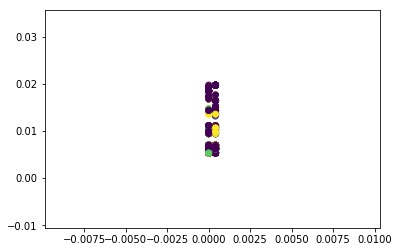

Time: 0.6430840492248535 seconds 
Comparing k-means clusters against the data:
author_id  1263465  1435222  1738456  1967875  2237917  2244144  2556543  \
row_0                                                                      
0               25        2        0       44       25       32       20   
1                0        1        0        0        0        0        0   
2                0        0       10        1        0        3        0   
3                0        0        4        0        0        0        0   
4                8        0        1        2        0       10        1   

author_id  2843565  2899838  2915457   ...    4236222  4264657  4274812  \
row_0                                  ...                                
0               14        6        1   ...          0        0        0   
1                0        0        0   ...          0        0        0   
2                0        0        1   ...          2        1        0   
3            

In [48]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_train_norm)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

This looks pretty good, at most an author is spread across 3 clusters, with 1 or 2 being the average. Let's try another amount of clusters to see if performance can be improved. I tried 2 clusters already and it was less effective.

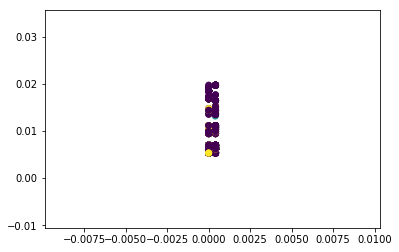

Time: 0.4547922611236572 seconds 
Comparing k-means clusters against the data:
author_id  1263465  1435222  1738456  1967875  2237917  2244144  2556543  \
row_0                                                                      
0               33        2        1       46       25       41       21   
1                0        1        0        0        0        0        0   
2                0        0       14        1        0        4        0   

author_id  2843565  2899838  2915457   ...    4236222  4264657  4274812  \
row_0                                  ...                                
0               14        6        3   ...          0        1        1   
1                0        0        0   ...          0        0        0   
2                0        0        1   ...          3        3        0   

author_id  4277498  4278196  4300739  4305115  4315343  4322723  579857  
row_0                                                                    
0               

In [49]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_train_norm)

#km = KMeans(n_clusters=num_clusters)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

# going to add the info back into the dataframe later
kmeans_clusters = y_pred

3 clusters seems pretty comparable to 5. Let's try one more value of n.

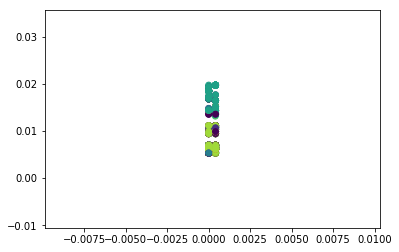

Time: 0.6260800361633301 seconds 
Comparing k-means clusters against the data:
author_id  1263465  1435222  1738456  1967875  2237917  2244144  2556543  \
row_0                                                                      
0               10        1        0        7        0        8        3   
1                1        0        3        0        0        7        0   
2                0        1        0        0        0        0        0   
3                0        0        3        0        0        0        0   
4                0        0        0        0       25        0        0   
5                0        0        0        0        0        0        0   
6               22        1        0       39        0       30       18   
7                0        0        9        1        0        0        0   

author_id  2843565  2899838  2915457   ...    4236222  4264657  4274812  \
row_0                                  ...                                
0         

In [50]:

start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=8, random_state=42).fit_predict(X_train_norm)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

8 clusters looks pretty bad to me compared to the others. Let's try mean shift and then move on with whichever is better -  kmeans with 3 clusters, or meanshift.

In [51]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 1


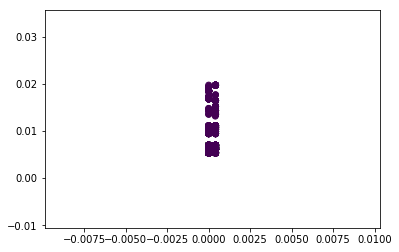

Comparing the assigned categories to the ones in the data:
col_0       0
author_id    
1263465    33
1435222     3
1738456    15
1967875    47
2237917    25
2244144    45
2556543    21
2843565    14
2899838     6
2915457     4
2974921    63
2994342     7
3047815     2
3057452    12
3132605    22


In [52]:
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels).head(15))

In [53]:
clusters = ms.labels_.tolist()

In [54]:
print(len(clusters), set(clusters))

1820 {0}


In [55]:
# put the clusters genereated from the Mean shift algorithm into the dataframe so we
# can analyze the clusters a little better
X_train['cluster'] = clusters

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:

X_train['kmeans_cluster'] = kmeans_clusters

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
X_train.head()

,gender,age,month,day,year,industry_Advertising,industry_Agriculture,industry_Architecture,industry_Arts,industry_Banking,...,write,fun,world,read,many,away,someone,most,cluster,kmeans_cluster
1380,1,26,6,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
712,0,15,7,2,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0
31,1,48,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969,1,15,8,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,2
655,1,17,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 4 - Features and models

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

In [58]:
# ok so recap, X_train is the X_train withOUT normalization 

X_train.head(3)

,gender,age,month,day,year,industry_Advertising,industry_Agriculture,industry_Architecture,industry_Arts,industry_Banking,...,write,fun,world,read,many,away,someone,most,cluster,kmeans_cluster
1380,1,26,6,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
712,0,15,7,2,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0
31,1,48,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###  tf-idf  (vectors for each post)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than 75 percent of the paragraphs
                             min_df=5, # only use words that appear at least n times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
lines_tfidf=vectorizer.fit_transform(df['post'])
print("Number of features: %d" % lines_tfidf.get_shape()[1])

# inititally tried model with parameters: max_df 0.75, min_df 10, # of features was 187

Number of features: 5210


In [60]:
print(lines_tfidf.shape)

(2427, 5210)


In [61]:
terms = vectorizer.get_feature_names()

In [62]:
lines_csr = lines_tfidf.tocsr()

In [63]:
#number of paragraphs
n = lines_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*lines_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = lines_csr[i, j]

In [64]:
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was
# present once in that sentence.
for i in range(3):
    print('Original sentence:', df.loc[i,'post'])
    print('Tf_idf vector:', tfidf_bypara[i])

Original sentence: urlLink Are the Browser Wars Back? - How Mozilla's Firefox trumps Internet Explorer. By Paul�Boutin I switched to Mozilla firefox about a week ago and its far superior to explorer. the ability to have multiple pages up sectioned by tabs has made my job much much more easier
Tf_idf vector: {'urllink': 0.08483191712776539, 'browser': 0.23241222756356292, 'wars': 0.2236503637618333, 'mozilla': 0.4794059305536084, 'internet': 0.1752841478381426, 'explorer': 0.4473007275236666, 'paul': 0.23241222756356292, 'switched': 0.2488336835210875, 'week': 0.12407057368649747, 'ago': 0.15604578784600565, 'far': 0.13999318633103475, 'superior': 0.24398224092321769, 'ability': 0.20891906605899946, 'multiple': 0.22925094322038383, 'pages': 0.20561389301079916, 'job': 0.14051595578945691, 'easier': 0.1873719635565427}
Original sentence: urlLink Feds warn against Microsoft's browser but the software giant's stock appeared not to feel a significant negative impact from a government group'

In [65]:
 # dimension reduction
    
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 4931 to the number below.
svd= TruncatedSVD(700)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
lines_lsa = lsa.fit_transform(lines_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(lines_lsa, #index=df['post']
                               )
#for i in range(5):
#    print('Component {}:'.format(i))
#    print(paras_by_component.loc[:50,i].sort_values(ascending=False)[0:5])   

Percent variance captured by all components: 70.04465806011859


In [66]:
paras_by_component.head(3)

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,0.079836,0.089571,-0.016804,-0.025353,-0.014502,-0.066009,0.042845,-0.030347,-0.014166,-0.007959,...,-0.005828,0.040123,-0.040129,0.027678,0.020728,-0.020904,-0.013917,-0.014246,0.005360,0.001148
1,0.103539,0.034143,-0.011961,-0.024460,0.012869,-0.065104,0.073070,-0.043694,-0.016713,0.024960,...,0.000781,-0.053773,0.018889,-0.027941,0.021912,0.013078,-0.019269,-0.019020,0.008700,0.011495
2,0.108872,0.183065,-0.027098,-0.002249,-0.009815,-0.031356,0.026245,-0.023967,-0.016922,0.000444,...,-0.027865,0.028087,0.033544,-0.018158,-0.022787,0.032246,-0.015968,0.032390,-0.033675,-0.028926


In [67]:
# add the components back into the dataframe as features

df = df.reset_index(drop=True)
paras_by_component = paras_by_component.reset_index(drop=True)

df = df.join(paras_by_component)

df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Advertising,industry_Agriculture,...,690,691,692,693,694,695,696,697,698,699
0,2237917,1,48,urlLink Are the Browser Wars Back? - How Mozil...,"(urlLink, Are, the, Browser, Wars, Back, ?, -,...",6,0,0,0,0,...,-0.005828,0.040123,-0.040129,0.027678,0.020728,-0.020904,-0.013917,-0.014246,0.005360,0.001148
1,2237917,1,48,urlLink Feds warn against Microsoft's browser ...,"(urlLink, Feds, warn, against, Microsoft, 's, ...",6,0,0,0,0,...,0.000781,-0.053773,0.018889,-0.027941,0.021912,0.013078,-0.019269,-0.019020,0.008700,0.011495
2,2237917,1,48,urlLink Business 2.0 - Magazine Article - The ...,"(urlLink, Business, 2.0, -, Magazine, Article,...",6,0,0,0,0,...,-0.027865,0.028087,0.033544,-0.018158,-0.022787,0.032246,-0.015968,0.032390,-0.033675,-0.028926
3,2237917,1,48,urlLink Fast Growth Database NICE!!! GHA Techn...,"(urlLink, Fast, Growth, Database, NICE, !, !, ...",6,0,0,0,0,...,-0.004423,0.015206,-0.002964,-0.010459,-0.019535,-0.057819,0.015117,0.072668,0.003059,-0.049385
4,2237917,1,48,urlLink Survey: Dell customer satisfaction uns...,"(urlLink, Survey, :, Dell, customer, satisfact...",6,0,0,0,0,...,-0.014164,-0.007187,0.005702,0.001360,0.010331,-0.014236,0.001066,-0.019812,-0.006705,-0.009893


Document similarity

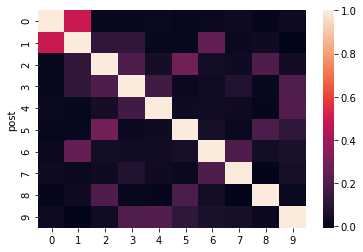

Key:
0 urlLink Are the Browser Wars Back? - How Mozilla's Firefox trumps Internet Explorer. By Paul�Boutin I switched to Mozilla firefox about a week ago and its far superior to explorer. the ability to have multiple pages up sectioned by tabs has made my job much much more easier
1 urlLink Feds warn against Microsoft's browser but the software giant's stock appeared not to feel a significant negative impact from a government group's warning against using the Internet Explorer Web browser. The U.S. Computer Emergency Readiness Team, known as CERT, issued a "vulnerability note" saying that computer users should not use the Internet Explorer browser because of security vulnerabilities that hackers can exploit to launch attacks on personal computers and corporate networks. Hmmm, that Bill Gates is one sly fella. GW should make him VP, cause @ this point microsoft can access just about anyones data @ any time.
2 urlLink Business 2.0 - Magazine Article - The Next Delivery? Computer Repairs 

In [68]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(lines_lsa) * np.asmatrix(lines_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=df['post']).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [69]:
print(similarity.shape, df.shape)


(2427, 2427) (2427, 891)


In [70]:
df.iloc[:3,:5]

,author_id,gender,age,post,parsed
0,2237917,1,48,urlLink Are the Browser Wars Back? - How Mozil...,"(urlLink, Are, the, Browser, Wars, Back, ?, -,..."
1,2237917,1,48,urlLink Feds warn against Microsoft's browser ...,"(urlLink, Feds, warn, against, Microsoft, 's, ..."
2,2237917,1,48,urlLink Business 2.0 - Magazine Article - The ...,"(urlLink, Business, 2.0, -, Magazine, Article,..."


In [71]:
# add the features back to the training and test sets

X_train = X_train.join(df.iloc[:,191:])
X_test = X_test.join(df.iloc[:,191:])

## models

a - gradient boosting

In [72]:
from sklearn.model_selection import cross_val_score

In [73]:
from sklearn import ensemble

In [74]:
#X_train_smaller = withbin.drop(['post','parsed'], 1)
#y_train

# training on smaller portions of X_train so I can test it on itself

X_train_smaller, X_test_smaller, y_train_smaller, y_test_smaller = train_test_split(X_train,
                                                                y_train, test_size=.25)

In [75]:
# with defaults - Training set score: 0.00846262341325811
#Test set score: 0.004739336492890996

clf = ensemble.GradientBoostingClassifier(n_estimators=200)


In [76]:
clf.fit(X_train_smaller, y_train_smaller)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [77]:
training_score = clf.score(X_train_smaller, y_train_smaller)

In [78]:
# need to get the clusters before i can run this
testing_score = clf.score(X_test_smaller, y_test_smaller)


In [79]:
print('Training set score:', training_score)
print('\nTest set score:', testing_score)

Training set score: 0.004395604395604396

Test set score: 0.006593406593406593


In [80]:
scores = cross_val_score(clf, X_train,y_train,cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.56 (+/- 0.06)


In [81]:
scores = cross_val_score(clf,X_train_smaller,y_train_smaller,cv=5)

print("Accuracy: %0.2f (+/- %0.2f)"% (scores.mean(), scores.std() *2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.53 (+/- 0.12)


b - logistic regression

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
lr = LogisticRegression()

train = lr.fit(X_train_smaller, y_train_smaller)


In [84]:
lr.score(X_train_smaller,y_train_smaller)

0.9992673992673993

In [85]:
lr.score(X_test_smaller, y_test_smaller)

0.6813186813186813

In [86]:
scores = cross_val_score(lr, X_test_smaller,y_test_smaller,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.63 (+/- 0.34)


c. random forest

In [87]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train_smaller,y_train_smaller)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
train = rfc.score(X_train_smaller,y_train_smaller)

In [89]:
test = rfc.score(X_test_smaller,y_test_smaller)

In [90]:
print('Training set score:', train)
print('\nTest set score:', test)

Training set score: 0.9992673992673993

Test set score: 0.545054945054945


In [91]:
scores = cross_val_score(rfc, X_test_smaller,y_test_smaller,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.51 (+/- 0.33)


# Part 5 - back to holdout group

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

### clustering on holdout group

first i need to normalize the data

In [92]:
X_test_norm = normalize(X_test)

K Means

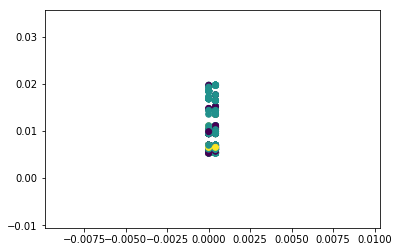

Time: 0.5503849983215332 seconds 
Comparing k-means clusters against the data:
author_id  1263465  1435222  1738456  1967875  2237917  2244144  2556543  \
row_0                                                                      
0                1        0        2        0        0        1        0   
1                9        0        0       12       14       14        7   
2                0        1        3        0        0        0        0   

author_id  2843565  2899838  2974921   ...    4198017  4214721  4236222  \
row_0                                  ...                                
0                0        0        6   ...          2        1        1   
1                7        3        8   ...          1        1        1   
2                0        0        1   ...          0        0        1   

author_id  4264657  4274812  4277498  4278196  4300739  4322723  579857  
row_0                                                                    
0               

In [93]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_test_norm)

# Plot the solution.
plt.scatter(X_test_norm[:, 0], X_test_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_test))

# going to add the info back into the dataframe later
kmeans_clusters = y_pred

Mean shift

Number of estimated clusters: 1


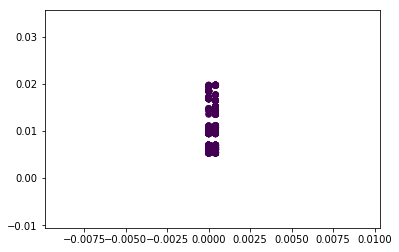

Comparing the assigned categories to the ones in the data:
col_0       0
author_id    
1263465    10
1435222     1
1738456     5
1967875    12
2237917    14
2244144    15
2556543     7
2843565     7
2899838     3
2974921    15
2994342     1
3057452     4
3132605     5
3139645     4
3155955     3


In [94]:
ms.fit(X_test_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_test_norm[:, 0], X_test_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_test,labels).head(15))


In [95]:
clusters = ms.labels_.tolist()

In [96]:
# add the clusters as features for the next step

X_test['cluster'] = clusters
X_test['kmeans_cluster'] = kmeans_clusters

## modelling

same steps to add the features, then using the previously fit models on the holdout data to see how it works

In [97]:
#X_test.columns.values

The model below won't work because a column is missing. Let's see what it is and add it if that is feasible.

In [98]:
#test_cols = X_test_bin.columns.values
#with_cols = withbin.columns.values

#for col in with_cols:
#    if col not in test_cols:
#        print(col)

In [99]:
# X_test_bin['industry_Advertising'] = 0

gradient boosting


In [100]:
new_testing_score = clf.score(X_test, y_test)

print('Holdout score:', new_testing_score)

Holdout score: 0.0032948929159802307


In [101]:
scores_gb = cross_val_score(clf,X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/-  %0.2f)" % (scores_gb.mean(), scores_gb.std()*2 ))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.53 (+/-  0.38)


logistic regression

In [102]:
lr.score(X_test, y_test)

0.6836902800658978

In [103]:
lr_cv = cross_val_score(lr,X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (lr_cv.mean(), lr_cv.std() * 2 ))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.63 (+/- 0.38)


random forest

In [104]:
rfc.score(X_test,y_test)

0.35584843492586493

In [105]:
scores = cross_val_score(rfc, X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.53 (+/- 0.38)
